In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import contourpy
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from _FigureJiazeHelper import *
from _DetectabilityWithMeta import *
from _CommunityDetect import *
from EXPERIMENT_MINORITY import *
from scipy.optimize import linear_sum_assignment

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=10)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 10  # 'large'
plt.rcParams['lines.markersize'] = 12
plt.rcParams['axes.linewidth'] = 0.5

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [9]:
def cm_for_network(delta, rho, n, d, Z_s, Z_b):
#     delta = 0.005
#     rho = 0.1
    pout = d / n - ((1-rho)**2 / Z_b + rho**2 / Z_s) * delta
    pin = pout + delta
    pin = 0 if pin < 1e-10 else pin
    pout = 0 if pout < 1e-10 else pout
    ps = (pin - pout) * np.identity(q) + pout * np.ones((q, q))
    n_f = int(n * (Z_s + Z_b) * (Z_b * rho + Z_s * (1 - rho)) / (Z_s * Z_b))
    rho_f = Z_b * rho / (Z_b * rho + Z_s * (1 - rho))
    n_fq = int(n_f / q)
    n_f = int(n_fq * q)
    sizes = [[n_fq] * Z_s, [n_fq] * Z_b]
    msbm = MetaSBM(n_f, rho_f, ps, sizes)
    A = msbm.sample()
    subA, subGroupId = msbm.filter(A, metaId=0)
    subTrueNumgroup = np.size(np.unique(subGroupId))
    subBHpartition, subBHNumgroup = CommunityDetect(subA).BetheHessian()
    print(f'True Sub Group Number is {subTrueNumgroup}')
    print(f'BH Sub Group Number is {subBHNumgroup}')
    confusionMatrix, _ = get_confusionmatrix(subGroupId, subBHpartition, subTrueNumgroup, subBHNumgroup)
    np.set_printoptions(suppress = True)
    print(f'rho is {rho}, AMI is {adjusted_mutual_info_score(subGroupId, subBHpartition)}, Confusion Matrix is\n {confusionMatrix}')
    fig = plt.figure(figsize=(4, 4))
    widths = [4]
    heights = [4]
    spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
    row = 0
    col = 0
    ax = fig.add_subplot(spec5[row, col])
    c = gen_colors(start=colors_red[0], end=colors_blue[0], n=6)
    _, indexes, counts = np.unique(subGroupId, return_index=True, return_counts=True)
    counts = counts[np.argsort(indexes)]
    plot_block_matrix(subA.toarray(), partition_names=list(range(6)), partition_counts=counts, colors=c, ms=0.01)
    return confusionMatrix

In [20]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [18]:
def plot_cm(confusionMatrix, rho, delta, fig=None, ax=None, yticks=True):
    subTrueNumgroup,subBHNumgroup = np.shape(confusionMatrix)
    rowsum = np.sum(confusionMatrix, axis=1)
    rowsum = rowsum.reshape(-1, 1)
    rowsum = np.repeat(rowsum, subBHNumgroup, axis=1)
    normConfusionMatrix = np.round(confusionMatrix / rowsum, 2)
    if fig is None and ax is None:
        fig = plt.figure(figsize=(3, 3))
        widths = [4]
        heights = [4]
        spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
        row = 0
        col = 0
        ax = fig.add_subplot(spec5[row, col])
#     cmap = mpl.colormaps["bwr_r"]
#     cmap = mpl.colormaps["RdYlBu"]
    cmap = mpl.colormaps["seismic_r"]
    cmap = truncate_colormap(cmap, 0.3, 0.7)
    im = ax.matshow(normConfusionMatrix, cmap=cmap, vmin=0, vmax=1)
    for i in range(subTrueNumgroup):
        for j in range(subBHNumgroup):
            c = normConfusionMatrix[i,j]
            ax.text(j, i, str(c), va='center', ha='center', fontsize=6)
#     ax.set_title(rf"$\rho={rho}, \delta={delta}$", fontsize=12)
    # ax.set_ylabel("True Community", rotation='horizontal', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10) if yticks else ax.set_yticks([])
    return im

In [12]:
# For big n
n = 6000
d = 50
Z_s = 2
Z_b = 3
q = Z_s + Z_b
Withlambda = True
givenNumGroup = False
DC = False
BP = False
fileID = 'amiExp24.1.23' + f'_n={n}_q={q}_d={round(d)}_{"lambda" if Withlambda else ""}_'\
                              f'{"givenNumGroup" if givenNumGroup else ""}_' \
                              f'{"DC" if DC else ""}_fixsubparameter_more'
load_path = "./result/detectabilityWithMeta/" + fileID + ".txt"
exclude_rho = np.setdiff1d(np.around(np.linspace(0, 1, 51), 2), np.array([]))[:21].tolist() + [1]
plot_rhos, plot_zs, sub_ami, sub_num_group, lambdas = read_exp(load_path=load_path, Withlambda=Withlambda, exclude_rho=exclude_rho)
plot_rhos = 1 - plot_rhos
print(np.unique(plot_rhos))

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58]


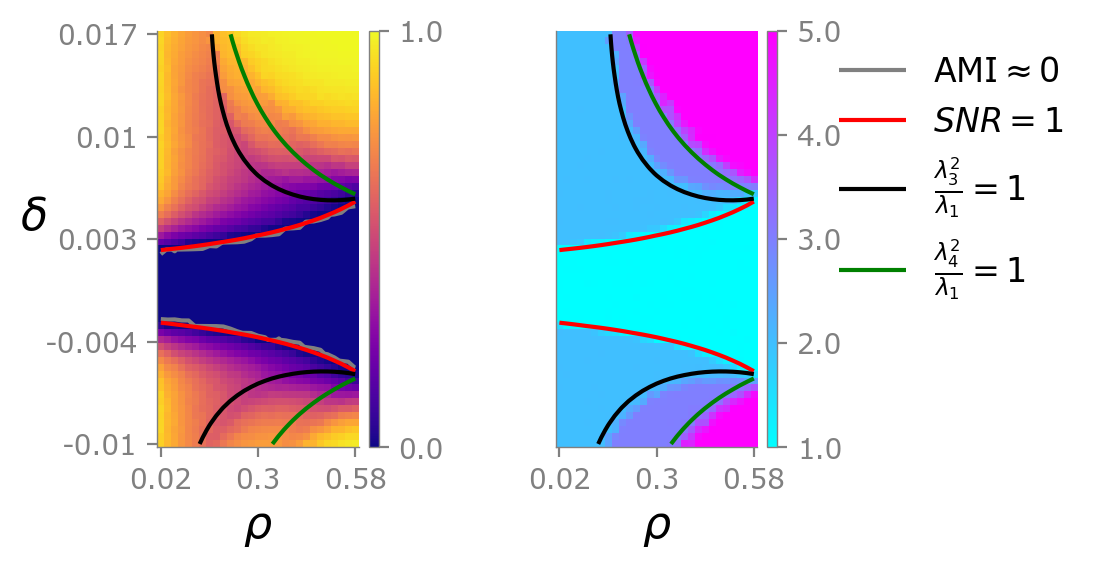

In [14]:
# figsize (width, height) with inch, 1 inch = 72 pt
fig = plt.figure(figsize=(4, 3))
widths = [3, 3]
heights = [3]
spec5 = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
cmap = mpl.colormaps["plasma"]
zcenter = 0.5
plot_subami = color_imshow_2d(plot_rhos, plot_zs, sub_ami, z_center=zcenter, title="", xlabel=r'$\rho$', ylabel=r'$\delta$', cmap=cmap, ax=ax, fig=fig, ytickprecision=3)
# ax.set_xlabel(r'$\rho$', fontsize=20)
handels = []
handels += contour_data(plot_subami, ax, levels=[1e-3], fmt={1e-3: r'AMI$\simeq$0'}, color='gray', inline=False)
plot_snrm = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 1]**2/lambdas[:, 0], z_center=1, return_gridz=True)
plot_l4overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 3]**2/lambdas[:, 0], z_center=1, return_gridz=True)
plot_l3overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 2]**2/lambdas[:, 0], z_center=1, return_gridz=True)
handels += contour_data(plot_snrm, ax, levels=[1], fmt={1: r'$SNR=1$'}, color='red', inline=False)

handels += contour_data(plot_l3overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_3^2}{\lambda_1}=1$'}, color='black', inline=False)
handels += contour_data(plot_l4overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_4^2}{\lambda_1}=1$'}, color='green', inline=False)
row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
cmap = mpl.colormaps["cool"]
plot_subnumgroup = color_imshow_2d(plot_rhos, plot_zs, sub_num_group, z_center=3, title="", xlabel=r'$\rho$', 
                                   ylabel=r'', cmap=cmap, ax=ax, fig=fig, vmax=5, ytickprecision=3, set_yticks=False)
plot_l4overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 3]**2/lambdas[:, 0], z_center=1, return_gridz=True)
plot_l3overl1 = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 2]**2/lambdas[:, 0], z_center=1, return_gridz=True)
plot_snrm = color_imshow_2d(plot_rhos, plot_zs, lambdas[:, 1]**2/lambdas[:, 0], z_center=1, return_gridz=True)
contour_data(plot_snrm, ax, levels=[1], fmt={1: r'$SNR=1$'}, color='red', inline=False)
contour_data(plot_l4overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_4^2}{\lambda_1}=1$'}, color='green', inline=False)
contour_data(plot_l3overl1, ax, levels=[1], fmt={1: r'$\frac{\lambda_3^2}{\lambda_1}=1$'}, color='black', inline=False)
lgd = fig.legend(handels, [r'AMI$\approx$0', r'$SNR=1$', r'$\frac{\lambda_3^2}{\lambda_1}=1$', r'$\frac{\lambda_4^2}{\lambda_1}=1$'], 
           loc=2, bbox_to_anchor=(0.94, 0.85),  fontsize=12, markerscale=2, frameon=False)
plt.subplots_adjust(wspace=0.8)
save_path = "./_Figure/Minority/" + "FigureMinorityAMISNR_" + f'Z_s{Z_s}Z_b{Z_b}' + "_v1.pdf"
# # plt.tight_layout()
plt.savefig(save_path, dpi=600, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [11]:
print(np.unique(plot_rhos))
print(np.unique(plot_zs))

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
[-0.01042 -0.00996 -0.0095  -0.00904 -0.00858 -0.00812 -0.00766 -0.0072
 -0.00674 -0.00629 -0.00583 -0.00537 -0.00491 -0.00445 -0.00399 -0.00353
 -0.00307 -0.00261 -0.00215 -0.00169 -0.00124 -0.00078 -0.00032  0.00014
  0.0006   0.00106  0.00152  0.00198  0.00244  0.0029   0.00335  0.00381
  0.00427  0.00473  0.00519  0.00565  0.00611  0.00657  0.00703  0.00749
  0.00794  0.0084   0.00886  0.00932  0.00978  0.01024  0.0107   0.01116
  0.01162  0.01208  0.01254  0.01299  0.01345  0.01391  0.01437  0.01483
  0.01529  0.01575  0.01621  0.01667]


Metadata generation done!
number of groups = 3, Kpos=3, Kneg=0
True Sub Group Number is 5
BH Sub Group Number is 3
True index is [2 3 4], Community detected index is [1 0 2]
rho is 0.1, AMI is 0.760321491785307, Confusion Matrix is
 [[ 105.  114.  108.]
 [ 102.  102.  100.]
 [1816.    5.    9.]
 [   5. 1792.    4.]
 [   8.    4. 1806.]]
Metadata generation done!
number of groups = 4, Kpos=4, Kneg=0
True Sub Group Number is 5
BH Sub Group Number is 4
True index is [1 2 3 4], Community detected index is [3 1 2 0]
rho is 0.22, AMI is 0.7118124167371959, Confusion Matrix is
 [[ 600.   31.   23.   31.]
 [ 649.   25.   24.   23.]
 [ 123. 1447.    9.    2.]
 [ 120.    5. 1416.    8.]
 [  82.    6.    9. 1453.]]
Metadata generation done!
number of groups = 5, Kpos=5, Kneg=0
True Sub Group Number is 5
BH Sub Group Number is 5
True index is [0 1 2 3 4], Community detected index is [0 3 1 4 2]
rho is 0.4, AMI is 0.7844491049104262, Confusion Matrix is
 [[1094.   16.   18.   29.   20.]
 [  26. 111

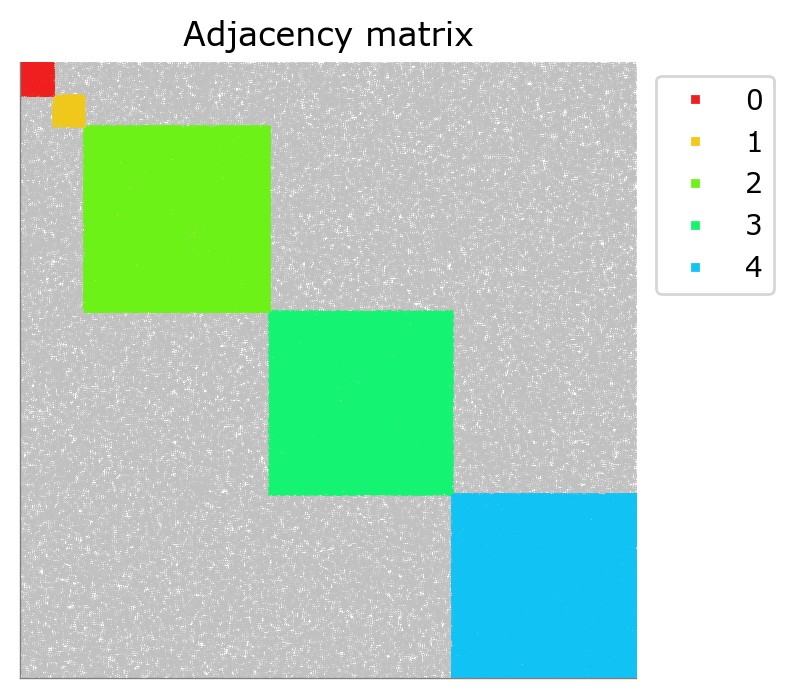

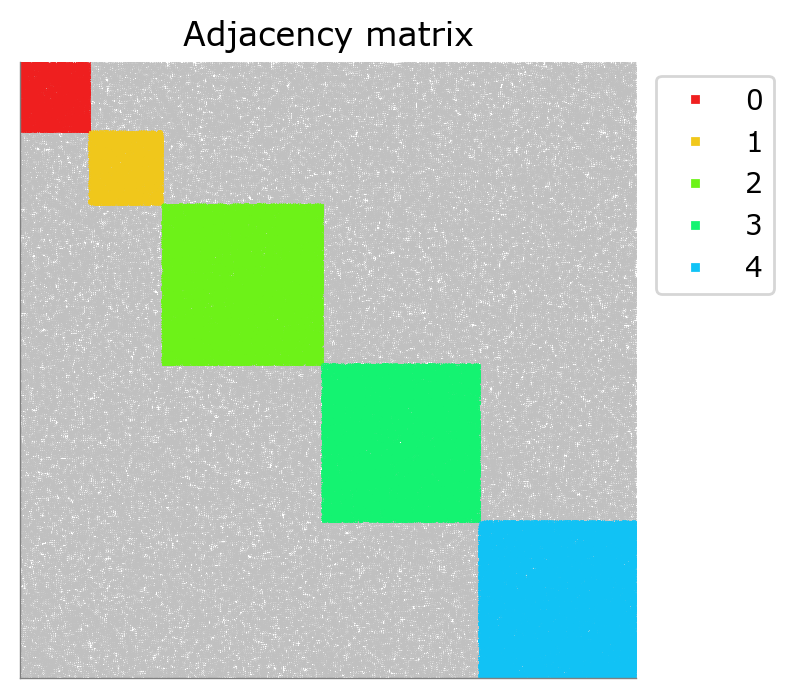

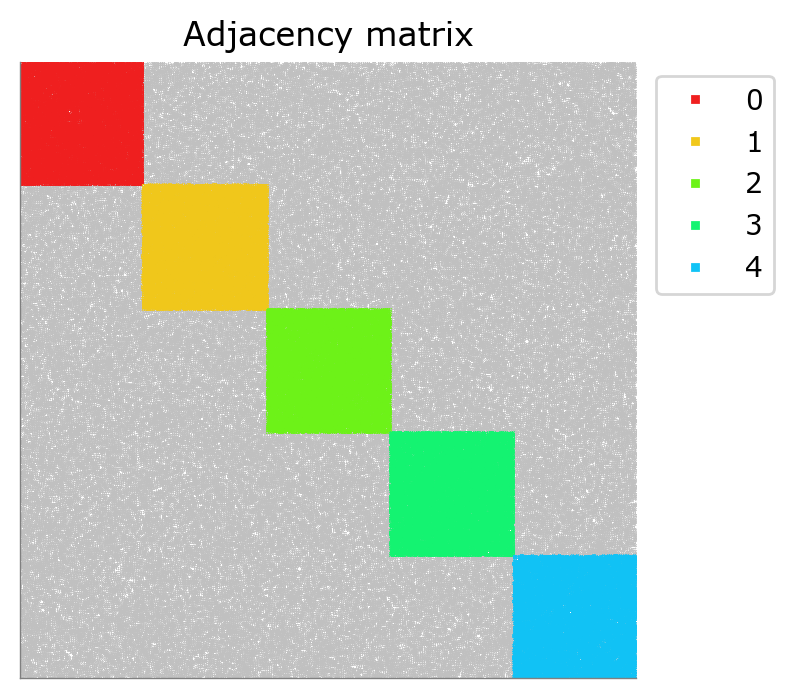

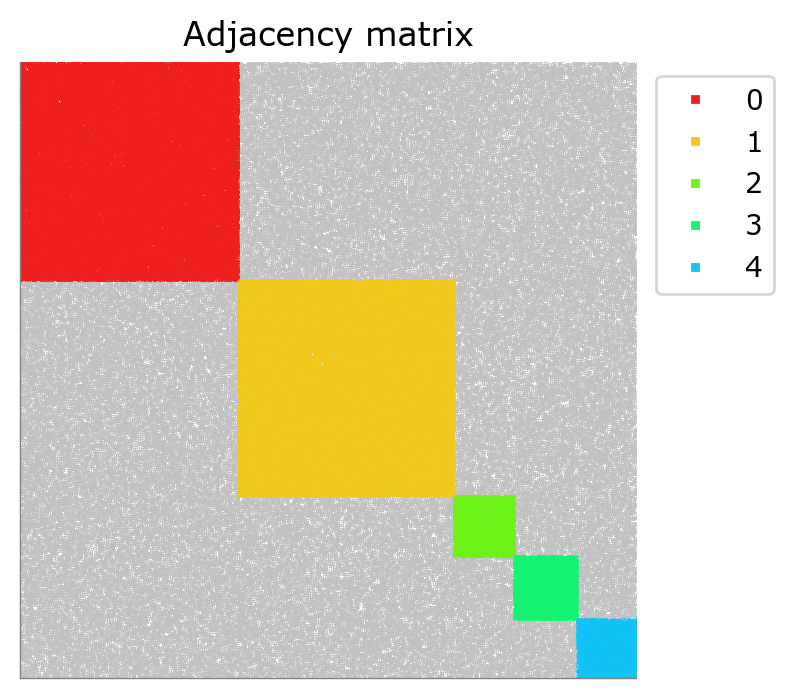

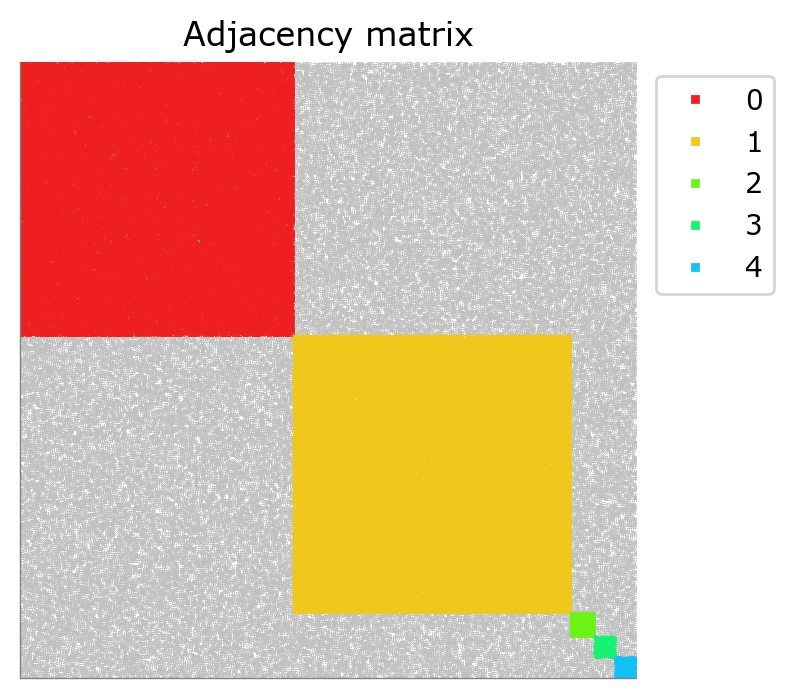

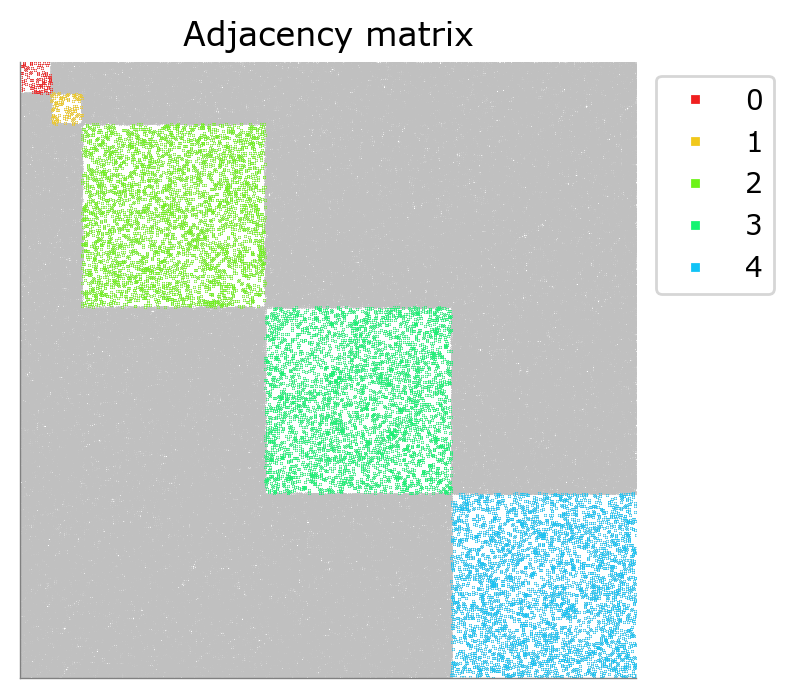

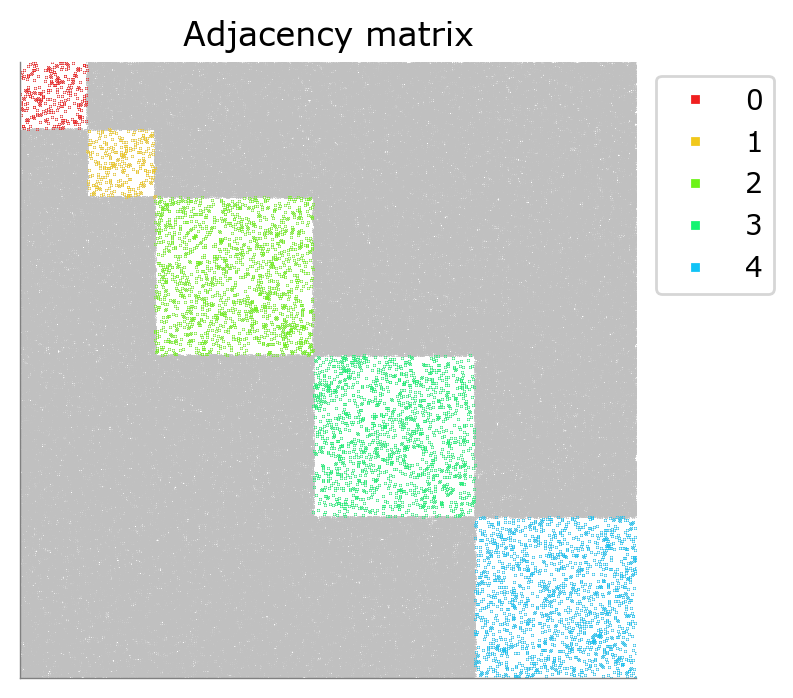

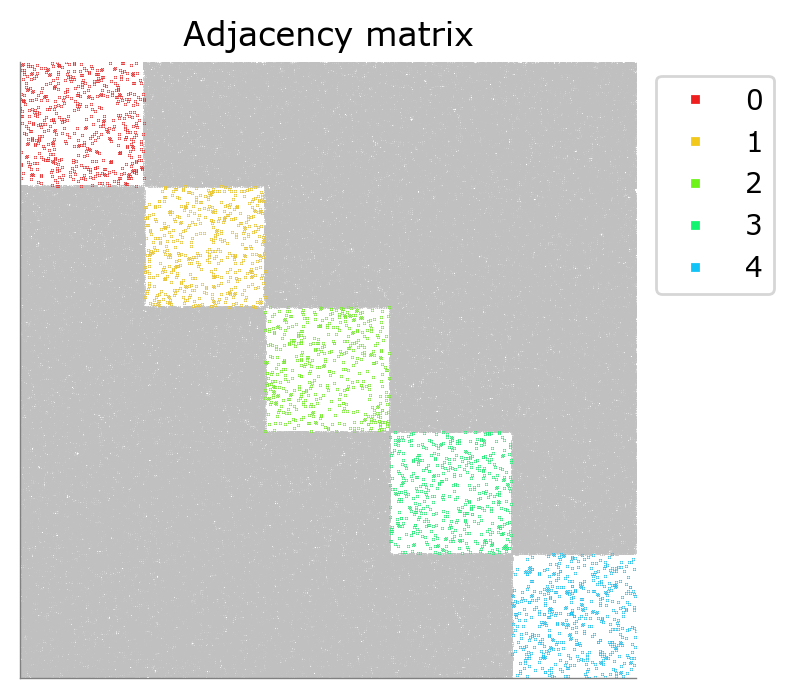

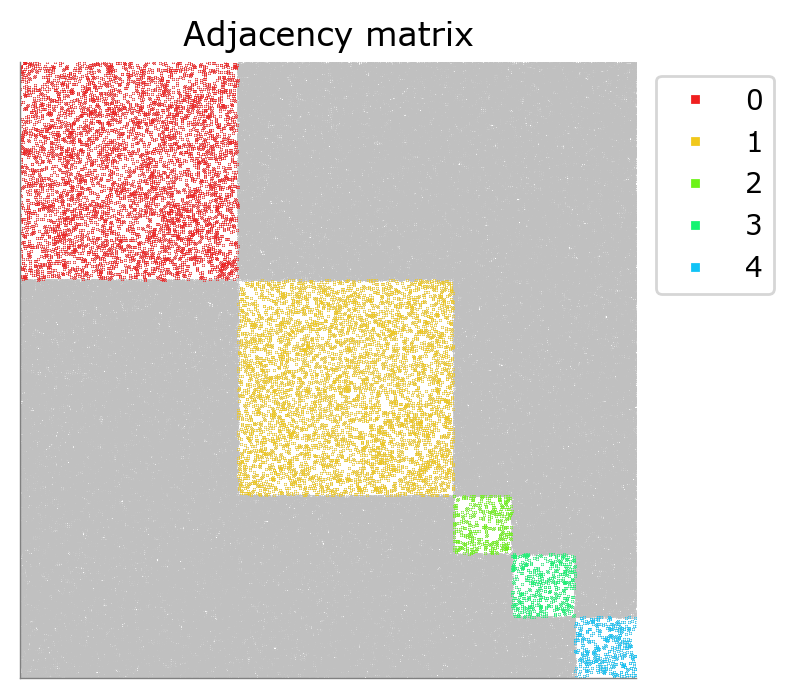

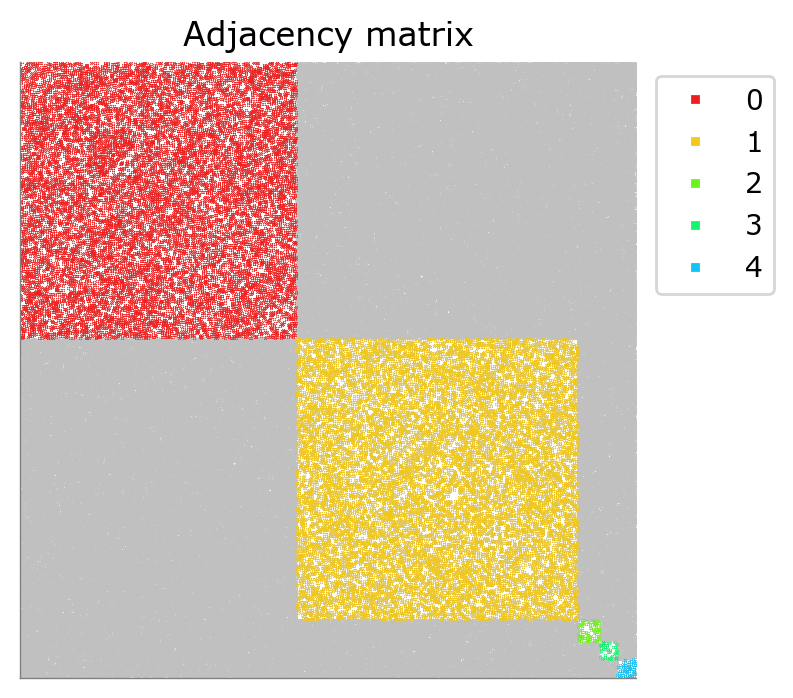

In [15]:
delta=0.01
rho=0.1
cm1 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.01
rho=0.22
cm2 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.01
rho=0.4
cm3 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.01
rho=0.7
cm4 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.01
rho=0.9
cm5 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.1
cm6 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.22
cm7 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.4
cm8 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.7
cm9 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.9
cm10 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

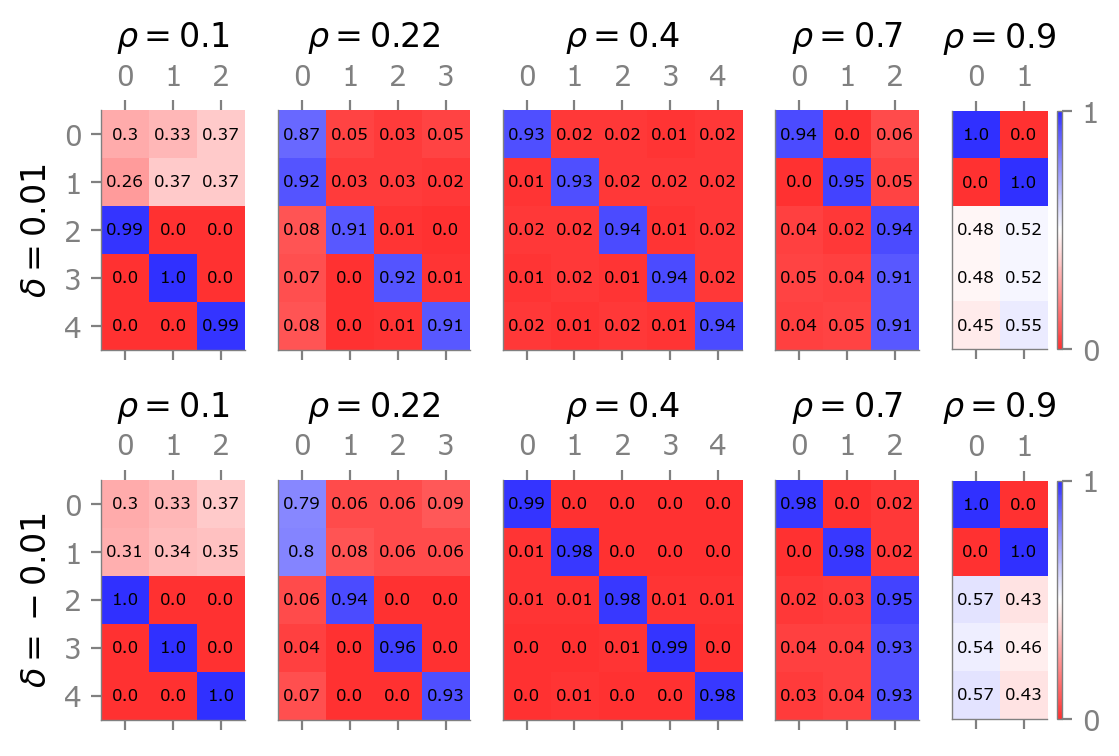

In [29]:
fig = plt.figure(figsize=(6.2, 4))
widths = [3, 4, 5, 3, 2.3]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=5, nrows=2, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.1
_ = plot_cm(confusionMatrix=cm1, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)
ax.set_ylabel(rf"$\delta={delta}$", rotation='vertical', fontsize=12)

row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.22
_ = plot_cm(confusionMatrix=cm2, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 0
col = 2
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.4
plot_cm(confusionMatrix=cm3, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 0
col = 3
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.7
plot_cm(confusionMatrix=cm4, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 0
col = 4
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.9
im = plot_cm(confusionMatrix=cm5, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# cticks = [0, 0.25, 0.5, 0.75, 1]
cticks = [0, 1]
clabels = ["0", "1"]
cbar = fig.colorbar(im, cax=cax, ticks=cticks)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_yticklabels(clabels)

row = 1
col = 0
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.1
_ = plot_cm(confusionMatrix=cm6, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)
ax.set_ylabel(rf"$\delta={delta}$", rotation='vertical', fontsize=12)

row = 1
col = 1
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.22
_ = plot_cm(confusionMatrix=cm7, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 1
col = 2
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.4
_ = plot_cm(confusionMatrix=cm8, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 1
col = 3
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.7
_ = plot_cm(confusionMatrix=cm9, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 1
col = 4
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.9
im = plot_cm(confusionMatrix=cm10, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# cticks = [0, 0.25, 0.5, 0.75, 1]
cticks = [0, 1]
clabels = ["0", "1"]
cbar = fig.colorbar(im, cax=cax, ticks=cticks)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_yticklabels(clabels)

plt.subplots_adjust(hspace=0.5)
save_path = "./_Figure/Minority/" + "FigureMinorityCM_" + f'Z_s{Z_s}Z_b{Z_b}' + ".pdf"
# plt.tight_layout()
plt.savefig(save_path, dpi=600)

# Reverse to Z_s=3, Z_b=2

Metadata generation done!
number of groups = 5, Kpos=5, Kneg=0
True Sub Group Number is 5
BH Sub Group Number is 5
True index is [0 1 2 3 4], Community detected index is [3 4 2 0 1]
rho is 0.5, AMI is 0.7432108180365525, Confusion Matrix is
 [[1430.    6.   28.   42.   34.]
 [  10. 1414.   34.   26.   29.]
 [  12.   16.  899.   62.   25.]
 [  18.   17.   43.  844.   33.]
 [   9.   11.   37.   49.  875.]]
Metadata generation done!
number of groups = 3, Kpos=3, Kneg=0
True Sub Group Number is 5
BH Sub Group Number is 3
True index is [0 1 2], Community detected index is [2 1 0]
rho is 0.7, AMI is 0.6360602015256314, Confusion Matrix is
 [[1915.    2.  178.]
 [   4. 1949.  123.]
 [  18.   26.  567.]
 [  26.   29.  564.]
 [  30.   28.  529.]]
Metadata generation done!
number of groups = 2, Kpos=2, Kneg=0
True Sub Group Number is 5
BH Sub Group Number is 2
True index is [0 1], Community detected index is [0 1]
rho is 0.9, AMI is 0.7115844928478338, Confusion Matrix is
 [[2691.    0.]
 [   0.

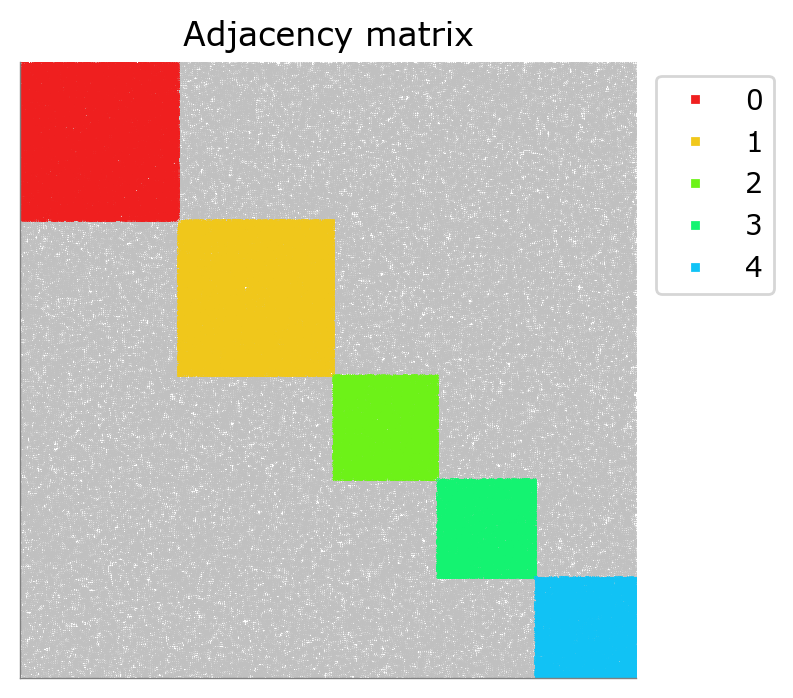

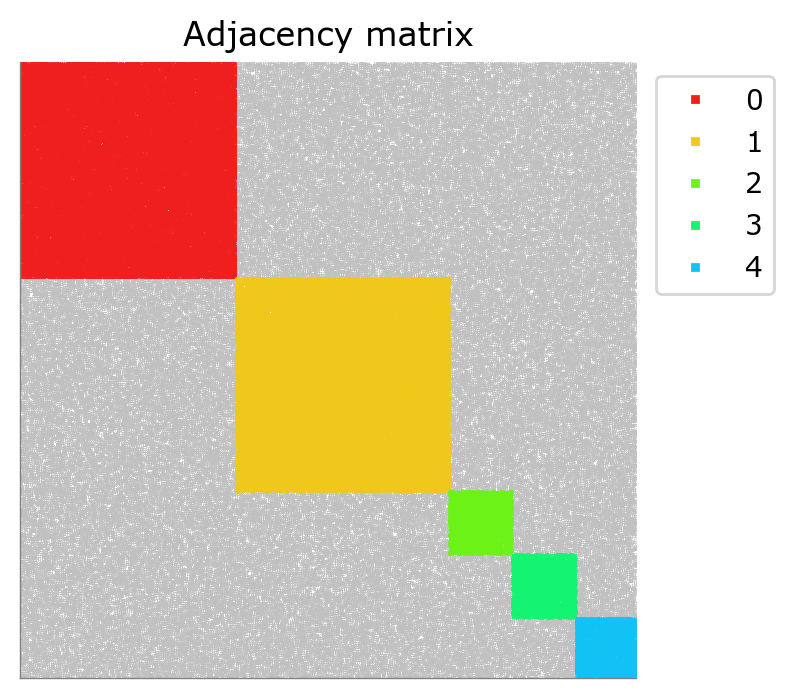

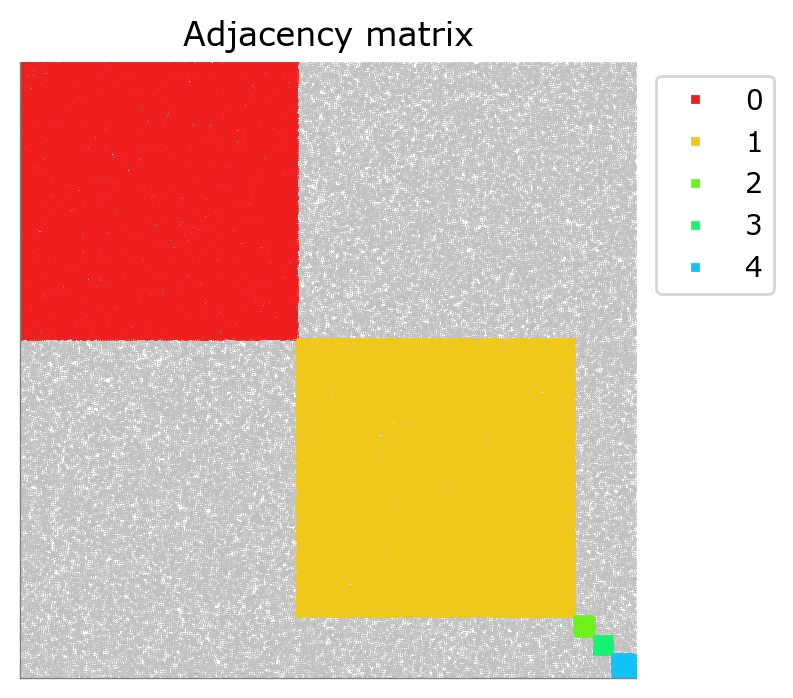

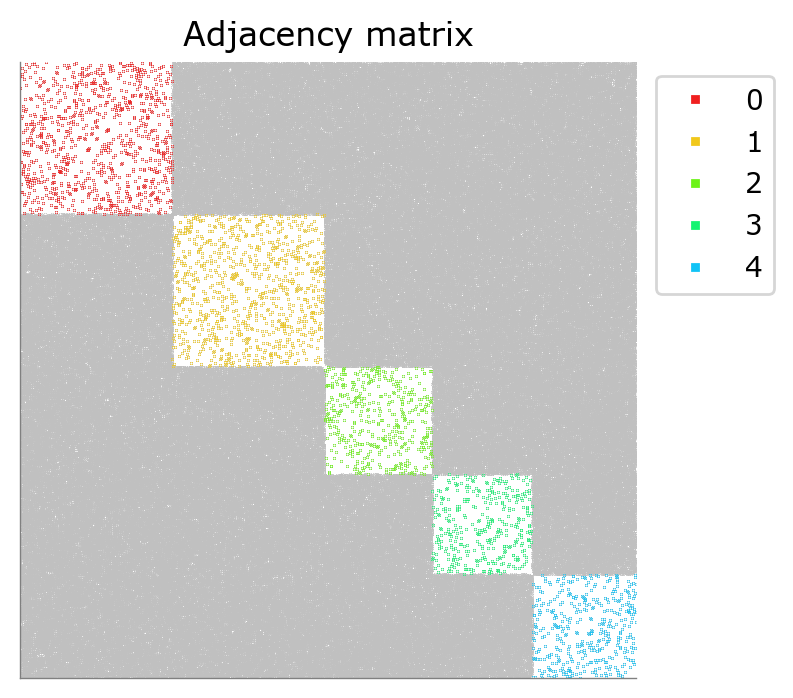

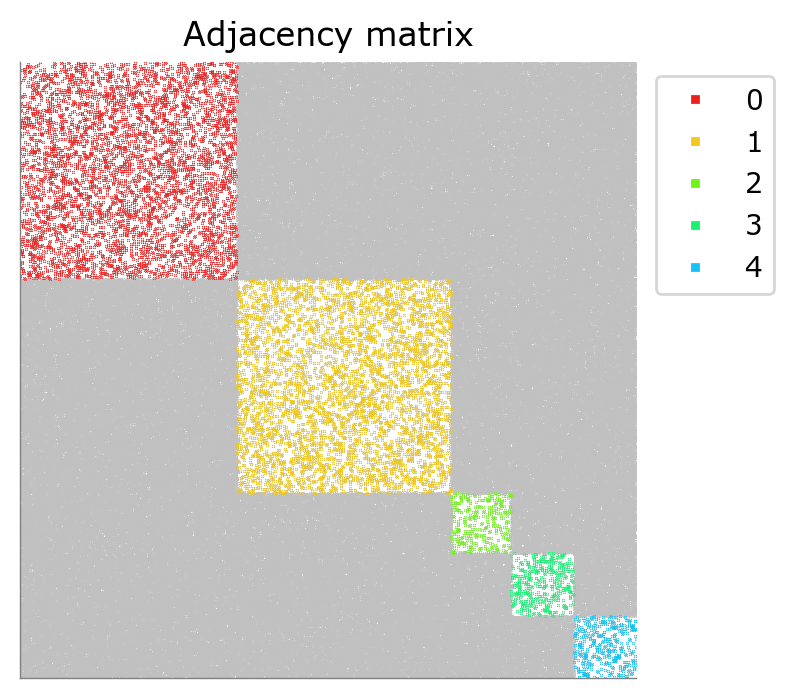

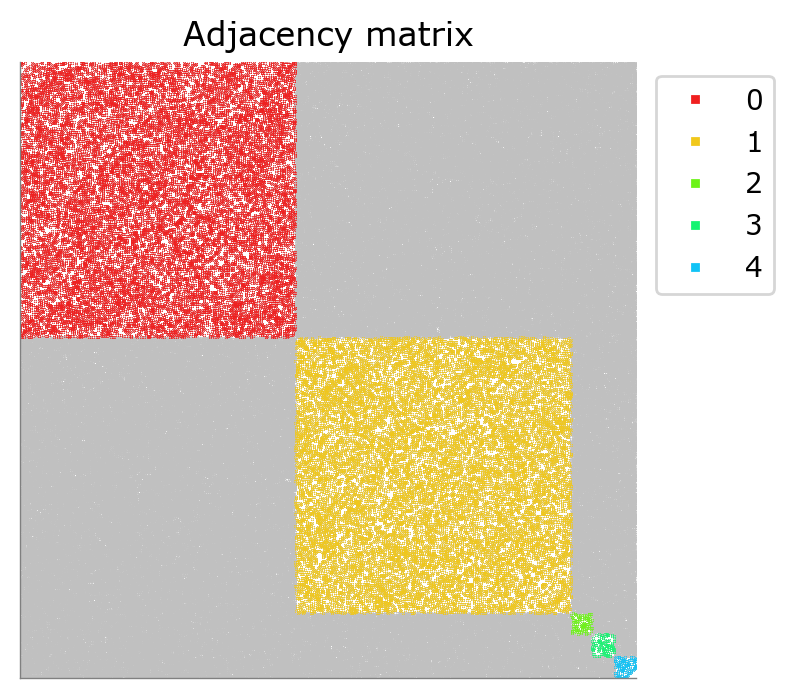

In [16]:
delta=0.01
rho=0.5
cm1 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.01
rho=0.7
cm2 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=0.01
rho=0.9
cm3 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.5
cm4 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.7
cm5 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

delta=-0.01
rho=0.9
cm6 = cm_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

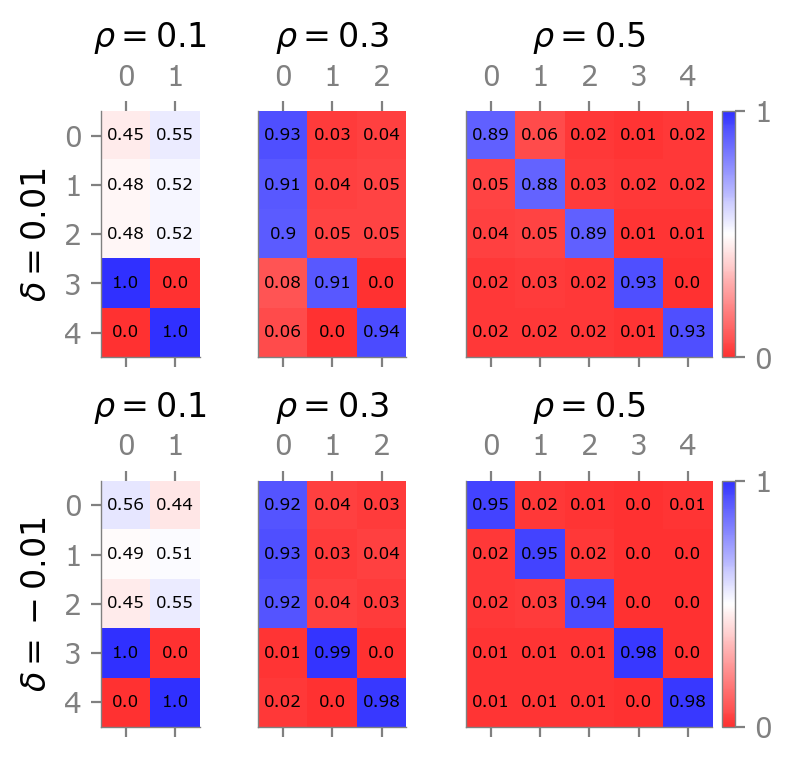

In [38]:
fig = plt.figure(figsize=(4.2, 4))
widths = [2, 3, 5]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.1
cm3_r = cm3[np.array([1, 2, 3, 4, 0]), :]
_ = plot_cm(confusionMatrix=cm3_r, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)
ax.set_ylabel(rf"$\delta={delta}$", rotation='vertical', fontsize=12)

row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.3
cm2_r = cm2[np.array([2, 3, 4, 0, 1]), :][:, np.array([2, 0, 1])]
_ = plot_cm(confusionMatrix=cm2_r, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 0
col = 2
ax = fig.add_subplot(spec5[row, col])
delta=0.01
rho=0.5
cm1_r = cm1[np.array([2, 3, 4, 0, 1]), :][:, np.array([2, 3, 4, 0, 1])]
im = plot_cm(confusionMatrix=cm1_r, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# cticks = [0, 0.25, 0.5, 0.75, 1]
cticks = [0, 1]
clabels = ["0", "1"]
cbar = fig.colorbar(im, cax=cax, ticks=cticks)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_yticklabels(clabels)

row = 1
col = 0
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.1
cm6_r = cm6[np.array([2, 3, 4, 0, 1]), :]
_ = plot_cm(confusionMatrix=cm6_r, rho=rho, delta=delta, fig=fig, ax=ax)
ax.set_title(rf"$\rho={rho}$", fontsize=12)
ax.set_ylabel(rf"$\delta={delta}$", rotation='vertical', fontsize=12)

row = 1
col = 1
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.3
cm5_r = cm5[np.array([2, 3, 4, 0, 1]), :][:, np.array([2, 0, 1])]
_ = plot_cm(confusionMatrix=cm5_r, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

row = 1
col = 2
ax = fig.add_subplot(spec5[row, col])
delta=-0.01
rho=0.5
cm4_r = cm4[np.array([2, 3, 4, 0, 1]), :][:, np.array([2, 3, 4, 0, 1])]
im = plot_cm(confusionMatrix=cm4_r, rho=rho, delta=delta, fig=fig, ax=ax, yticks=False)
ax.set_title(rf"$\rho={rho}$", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# cticks = [0, 0.25, 0.5, 0.75, 1]
cticks = [0, 1]
clabels = ["0", "1"]
cbar = fig.colorbar(im, cax=cax, ticks=cticks)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_yticklabels(clabels)

plt.subplots_adjust(hspace=0.5)
save_path = "./_Figure/Minority/" + "FigureMinorityCM_" + f'Z_s{3}Z_b{2}' + ".pdf"
# plt.tight_layout()
plt.savefig(save_path, dpi=600)